# Ex 2 - SLC Datacube I/O

In this example, we will open a stack of Single Look Complex (SLC) images, read them in as a `SARDatacube` object, display the array data, perform some simple metadata queries, and save the stack of images. The SLC files from ICEYE are in the.hdf5 format.

In [1]:
import os,sys,inspect
from os.path import dirname, abspath, join
from icecube.bin.sar_cube.slc_datacube import SLCDatacube
from icecube.bin.config import CubeConfig 
import matplotlib.pyplot as plt
from pathlib import Path 
from icecube.bin.datacube_variables import NAME_REAL_BAND, NAME_COMPLEX_BAND
import numpy as np

## Creating  a Datacube

Modify the following paths based of your use case. For the purpose of this demo, we'll work on a subset of the images used to test the library.

In [2]:
parent_dir = dirname(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))
test_dir =  join(parent_dir, "tests", "resources", "slc_stack")
print(f"The SLCs used for the demo are located at Path_to_library/icecube/tests/resources/slc_stack")

The SLCs used for the demo are located at Path_to_library/icecube/tests/resources/slc_stack


The first step is to create or edit the config file, which is a json file containing the parameters that you want to modify for the datacube construction.

In [3]:
cube_config = CubeConfig()

# To load the config parameters;
#cube_config.load_config(cube_config_path)

# Example json:
#{
#    "start_date": "20200402",
#    "end_date": "20210420",
#    "min_incidence_angle": 20,
#    "max_incidence_angle": 21,
#    "temporal_resolution": 1,
#    "coregistered": true,
#    "space_overlap": true,
#    "temporal_overlap": true
#}

In [4]:
# Build the datacube composed of a stack of SLC

# The program will execute the following steps:
#  - Fetch the metadata of the images
#  - Build a dataframe containing the metadata
#  - Apply the filtering (sort by date, select by angle)
#  - From the filtered metadata, it will load the data accordingly 

slc_datacube = SLCDatacube.build(cube_config, test_dir)

08/31/2021 10:38:30 AM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /home/adupeyrat/Documents/code/icecube/tests/resources/slc_stack using SLC
processing rasters for cubes: 100%|██████████| 3/3 [00:00<00:00, 27.73it/s]
08/31/2021 10:38:31 AM - common_utils.py - [INFO] - create running time is 0.1698 seconds


## `SLCDatacube` object

Every `SLCDatacube` object is a `SARDatacube`

These have multiple methods:

- `.cube_config` -> As seen above, the configuration is used to create the datacube. We can modify those parameters by defining a json file that will load each parameters.


- `.xrdataset` -> This is theXarray.Dataset containing the stack of images (Azimuth, Range, and Band). Each image is loaded using dask (for memory optimization) and then tranformed into an Xarray.Dataarray. There is one temporal layer in the datacube for each SLC file found in your directory.


- `.get_metadata(temporal_index)` ->  Returns the metadata of the image at a certain index, this is the Dict[str, str] representing the images.

In [5]:
# You can access the dataset for ease of visualization,
# The 'Band' dimension shows the number of SLC images stacked from your input path
slc_datacube.xrdataset.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (Azimuth: 20, Band: 3, Range: 20)
Coordinates:
  * Azimuth  (Azimuth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Range    (Range) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Band     (Band) datetime64[ns] 2021-04-27 2021-04-28 2021-05-27
Data variables:
    Real     (Band, Azimuth, Range) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    Complex  (Band, Azimuth, Range) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>>

In [6]:
# Access the array dimensions
slc_datacube.xrdataset.dims

Frozen(SortedKeysDict({'Azimuth': 20, 'Range': 20, 'Band': 3}))

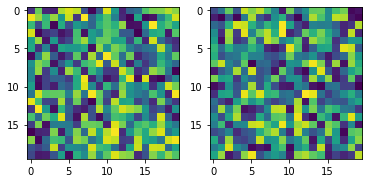

In [7]:
# Let's visualize the Complex component of the slc_datacube for the first and last image of the stack.
# Will convert the data to bytes (from float64), so we can see something.

fig, ax = plt.subplots(1,2)

#First image in the stack
ax[0].imshow(slc_datacube.xrdataset['Real'][0].values)

#Last image in the stack
ax[1].imshow(slc_datacube.xrdataset['Real'][-1].values)


In [8]:
# Slice the stack at a pixel level. If the SLC stack images are co-located at different times, you are slicing by time at this point:
# Let's pick the first pixel in range and aziumuth for all images in the stack. 

#Check the shape of the stack again
print(slc_datacube.xrdataset['Complex'].shape)

#The stack depth is the first dimension of the array
pixel_time_series = slc_datacube.xrdataset['Complex'][:,1,1].values
print(f"The time series for the pixel located at the pixel (1,1) is {pixel_time_series}")


(3, 20, 20)
The time series for the pixel located at the pixel (1,1) is [0.51176447 0.92778593 0.350109  ]


The raw ICEYE image metadata for each image can be accessed using the method `get_metadata(attributes, datavars, cube_index)`or directly using attrs of the xarray.Dataset[data_vars].


slc_datacube.xrdataset["Complex"].attrs will return a dict[str, list]

- `The key` represents the metadata key
- `The values` represents the values associated with each layer of the datacube - a missing value is represented by `None`


In [9]:
# Visualize all possibles values
slc_datacube.xrdataset['Complex'].attrs.keys()

dict_keys(['product_type', 'fsl_compensation', 'angY', 'processing_time', 'incidence_far', 'slant_range_to_first_pixel', 'carrier_frequency', 'range_looks', 'RPC_SAMP_OFF', 'acquisition_start_utc', 'chirp_bandwidth', 'chirp_duration', 'state_vector_time_utc', 'data_orientation', 'look_side', 'orbit_repeat_cycle', 'slant_range_spacing', 'zerodoppler_start_utc', 'sample_precision', 'acquisition_end_utc', 'RPC_LONG_OFF', 'posX', 'window_function_range', 'orbit_processing_level', 'incidence_near', 'processing_prf', 'RPC_LAT_OFF', 'RPC_HEIGHT_SCALE', 'RPC_LINE_DEN_COEFF', 'geo_ref_system', 'RPC_SAMP_NUM_COEFF', 'RPC_LINE_OFF', 'dc_estimate_coeffs', 'azimuth_time_interval', 'local_incidence_angle', 'azimuth_looks', 'coord_first_far', 'dc_estimate_poly_order', 'dc_estimate_time_utc', 'coord_last_near', 'doppler_rate_poly_order', 'product_name', 'number_of_azimuth_samples', 'azimuth_angles_of_the_beam', 'incidence_center', 'azimuth_ground_spacing', 'RPC_SAMP_DEN_COEFF', 'number_of_state_vector

In [10]:
# You can see the list of values for a specific metadata
slc_datacube.xrdataset['Complex'].attrs["product_file"]

['ICEYE_SLC_54549_20210427T215124_hollow_20x20pixels_fake_1.h5',
 'ICEYE_SLC_54549_20210427T215124_hollow_20x20pixels_fake_0.h5',
 'ICEYE_SLC_54549_20210427T215124_hollow_20x20pixels_fake_2.h5']

In [11]:
# If you know what you are looking for, you can directly use `get_metadata(attr, var, index)` method
slc_datacube.get_metadata("product_file", NAME_COMPLEX_BAND, 1)

'ICEYE_SLC_54549_20210427T215124_hollow_20x20pixels_fake_0.h5'

# The temporal Resolution

By modifying the cube_config variable, you are able to adjust the time resolution - the empty time slot will be replaced by empty data (np.nan) for the array and None for the metadata.

In [12]:
cube_config = CubeConfig()
cube_config.temporal_resolution = 2
cube_config.start_date = 20210427 # end of April
cube_config.end_date = 20210501 # begining of May - 6 days difference
cube_config.load_config(None)

# Build the datacube composed by a stack of SLC
slc_datacube = SLCDatacube.build(cube_config, test_dir)

08/31/2021 10:38:31 AM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /home/adupeyrat/Documents/code/icecube/tests/resources/slc_stack using SLC
processing rasters for cubes: 100%|██████████| 3/3 [00:00<00:00, 57.45it/s]
08/31/2021 10:38:31 AM - common_utils.py - [INFO] - create running time is 0.1104 seconds


In [13]:
slc_datacube.xrdataset[NAME_COMPLEX_BAND].attrs["acquisition_end_utc"]

['2021-04-27T21:51:30.025535', 'None', 'None']

In [14]:
np.isnan(slc_datacube.xrdataset[NAME_COMPLEX_BAND][1].values).all()

True

# The filtering by date

The datacube is built with the time component as coordinate. By doing so, we have the possibility to query the datacube using the acquisition date of the image. That is really useful when you are looking for a specific time or an interval of time.

In [15]:
# Single date
slc_datacube.xrdataset.sel(Band="2021-04-27").head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (Azimuth: 20, Range: 20)
Coordinates:
  * Azimuth  (Azimuth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Range    (Range) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
    Band     datetime64[ns] 2021-04-27
Data variables:
    Real     (Azimuth, Range) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    Complex  (Azimuth, Range) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>>

In [16]:
# Interval
slc_datacube.xrdataset.sel(Band=slice("2021-04-27", "2021-04-30")).head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (Azimuth: 20, Band: 2, Range: 20)
Coordinates:
  * Azimuth  (Azimuth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Range    (Range) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Band     (Band) datetime64[ns] 2021-04-27 2021-04-29
Data variables:
    Real     (Band, Azimuth, Range) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    Complex  (Band, Azimuth, Range) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>>

## Build datacube from a list of path

It's also possible to build a datacube from a list of path instead of a local folder. For that, you will need to call the `build_from_list()` function instead of `build()`. The method will build your datacube taking into account only the files in your list. In the following example, we will reduce the inputs to only two images instead of three.

In [17]:
# Build the datacube composed of a stack of SLC
list_interesting_paths = [Path(join(test_dir, cur_path)) for cur_path in os.listdir(test_dir)[:2]]
print(list_interesting_paths)

[PosixPath('/home/adupeyrat/Documents/code/icecube/tests/resources/slc_stack/ICEYE_SLC_54549_20210427T215124_hollow_20x20pixels_fake_1.h5'), PosixPath('/home/adupeyrat/Documents/code/icecube/tests/resources/slc_stack/ICEYE_SLC_54549_20210427T215124_hollow_20x20pixels_fake_2.h5')]


In [18]:
# Build the datacube composed of a stack of SLC
cube_config = CubeConfig()
slc_datacube = SLCDatacube.build_from_list(cube_config, list_interesting_paths)

08/31/2021 10:38:31 AM - sar_datacube_metadata.py - [INFO] - Building the metadata from the list [PosixPath('/home/adupeyrat/Documents/code/icecube/tests/resources/slc_stack/ICEYE_SLC_54549_20210427T215124_hollow_20x20pixels_fake_1.h5'), PosixPath('/home/adupeyrat/Documents/code/icecube/tests/resources/slc_stack/ICEYE_SLC_54549_20210427T215124_hollow_20x20pixels_fake_2.h5')]
processing rasters for cubes: 100%|██████████| 2/2 [00:00<00:00, 26.22it/s]
08/31/2021 10:38:31 AM - common_utils.py - [INFO] - create_from_list running time is 0.1211 seconds


In [19]:
slc_datacube.xrdataset.dims

Frozen(SortedKeysDict({'Azimuth': 20, 'Range': 20, 'Band': 2}))

## Writing a file to GeoTiff

Finally, save the datacube using the `.to_file()` method of the `SarDatacube` object. The default format is `netCDF4`.

In [20]:
slc_datacube.to_file(output_fpath="my_awesome_datacube_slc.nc")

hyvää työtä!